In [1]:
# Import libraries and set desired options
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the training and test data sets, change paths if needed
train_df = pd.read_csv('all/train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('all/test_sessions.csv',
                      index_col='session_id')

In [3]:
# Convert time1, ..., time10 columns to datetime type
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

In [4]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary
with open(r"all/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])

Websites total: 48371


In [5]:
# Меняю местами key и value в словарике и удаляю 'www', что бы лишнего шума не создовать
site_dict_inv = dict((v,k.replace('www.', '')) for k,v in site_dict.items())

In [6]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]
idx_valid = int(np.round(idx_split * 0.8))

In [7]:
# Create a separate dataframe where we will work with timestamps
time_df = pd.DataFrame(index=full_df.index)
# Find sessions' starting and ending
time_df['min'] = full_df[times].min(axis=1)
time_df['max'] = full_df[times].max(axis=1)
# Calculate sessions' duration in seconds
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

In [8]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]

In [9]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [10]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')
full_new_feat['start_hour'] = full_df['time1'].dt.hour
full_new_feat['morning'] = full_new_feat['start_hour'].apply(lambda x: 1 if x <= 11 else 0)

### Посмотрю распределение классов на трейне и валидации

In [11]:
y_train[:idx_valid].value_counts()

0    200876
1      1973
Name: target, dtype: int64

In [12]:
y_train[idx_valid:].value_counts()

0    50388
1      324
Name: target, dtype: int64

### Это baseline

In [16]:
Cs = 0.1668100537200059

In [15]:
feat_one = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:],
                             feat_one[:idx_split,:]]))
get_auc_lr_valid(X_train, y_train, C=Cs)

### Делаю TfIdf матрицу

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV

In [12]:
# Добавляю колонку где будут указаны сайты в виде текста
full_df['text'] = full_df[sites].apply(lambda x: " ".join([str(site_dict_inv[a]) for a in x.values if a != 0]), axis=1)

In [18]:
tf_idf = TfidfVectorizer(ngram_range=(1, 3), max_features=50000)
full_tfidf = tf_idf.fit_transform(full_df['text'])

In [17]:
time_split = TimeSeriesSplit(n_splits=10)
logit = LogisticRegression(C=Cs, random_state=17)
cross = cross_val_score(logit, full_tfidf[:idx_valid, :], y_train[:idx_valid], cv=time_split, error_score='roc_auc', n_jobs=-1)

In [18]:
cross, cross.mean()

(array([0.96854664, 0.99392625, 0.98497831, 0.99408894, 0.9989154 ,
        0.98828633, 0.99994577, 0.98953362, 0.99962039, 0.97993492]),
 0.9897776572668112)

In [69]:
#tmp = LogisticRegression(penalty='l1', random_state=17)
#tmp.fit(full_tfidf[:idx_valid, :], y_train[:idx_valid])
#roc_auc_score(y_train[idx_valid:], tmp.predict_proba(full_tfidf[idx_valid:idx_split, :])[:, 1])
#y_test = np.round(tmp.predict_proba(full_tfidf[idx_split:, :])[:, 1])
#pd.DataFrame(y_test, index=np.arange(1, y_test.shape[0] + 1), columns=['target']).\
#        to_csv('subs/test.csv', index_label="session_id")

**Только tf_idf фичи показывают хорошие результаты на кросс-валидации и отложенной выборке, но ужастные на лидер борде**  
На отложенной - 92  
На лидер борде - 53

### Теперь сделаю Count_Vectorizer и проверю его результаты без временных фичей

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
clv = CountVectorizer(ngram_range=(2,3), max_features=50000)

In [20]:
with open('full_df_text.txt') as inp_train_file:
    full_vectorized = clv.fit_transform(inp_train_file)

In [21]:
cross = cross_val_score(logit, full_vectorized[:idx_valid, :], y_train[:idx_valid], cv=time_split, error_score='roc_auc', n_jobs=-1)
cross, cross.mean()

(array([0.96860087, 0.98839479, 0.98313449, 0.99354664, 0.99831887,
        0.98861171, 0.99978308, 0.99061822, 0.9994577 , 0.97950108]),
 0.9889967462039045)

In [78]:
#tmp = LogisticRegression(penalty='l1', random_state=17)
#tmp.fit(full_vectorized[:idx_valid, :], y_train[:idx_valid])
#roc_auc_score(y_train[idx_valid:], tmp.predict_proba(full_tfidf[idx_valid:idx_split, :])[:, 1])
#y_test = np.round(tmp.predict_proba(full_tfidf[idx_split:, :])[:, 1])
#pd.DataFrame(y_test, index=np.arange(1, y_test.shape[0] + 1), columns=['target']).\
#        to_csv('subs/test.csv', index_label="session_id")

**Результат как и у tf_idf. Хороший результат на кросс-валидации, но плохой на лидер борде**  
На кросс - 98  
На лидер борде - 50

### Начинаю создавать новые фичи

In [18]:
new_features = pd.DataFrame(index=full_df.index)
new_features['second'] = time_df['seconds']

In [23]:
tmp_train = csr_matrix(hstack([full_tfidf[:idx_valid, :],
                              new_features['second'].values[:idx_valid, np.newaxis]]))
cross = cross_val_score(logit, tmp_train, y_train[:idx_valid], cv=time_split, error_score='roc_auc', n_jobs=-1)
cross, cross.mean()

(array([0.96854664, 0.99392625, 0.98497831, 0.99408894, 0.9989154 ,
        0.98828633, 0.99994577, 0.98953362, 0.99962039, 0.97988069]),
 0.989772234273319)

In [19]:
new_features['month'] = full_df['time1'].dt.month
new_features['year'] = full_df['time1'].dt.year
new_features['n_unique'] = full_df[sites].apply(lambda x: x[x != 0].nunique(), axis = 1)

In [39]:
sct = StandardScaler()
tmp_scaled = sct.fit_transform(new_features)
tmp_train = csr_matrix(hstack([full_tfidf[:idx_valid, :],
                              tmp_scaled[:idx_valid, :]]))
cross = cross_val_score(logit, tmp_train, y_train[:idx_valid], cv=time_split, error_score='roc_auc', n_jobs=-1)
cross, cross.mean()

(array([0.96854664, 0.99061822, 0.98232104, 0.5626898 , 0.9989154 ,
        0.98828633, 0.99994577, 0.98953362, 0.99962039, 0.97993492]),
 0.9460412147505423)

Интересно, что год ухудшает результат. Но попробую залить результат с ним и посмотреть на результат

In [20]:
new_features['hour'] = full_df['time1'].dt.hour

In [38]:
sct = StandardScaler()
tmp_scaled = sct.fit_transform(new_features)
tmp_train = csr_matrix(hstack([full_tfidf[:idx_valid, :],
                              tmp_scaled[:idx_valid, :]]))
cross = cross_val_score(logit, tmp_train, y_train[:idx_valid], cv=time_split, error_score='roc_auc', n_jobs=-1)
cross, cross.mean()

(array([0.96854664, 0.99061822, 0.98232104, 0.5626898 , 0.9989154 ,
        0.98828633, 0.99994577, 0.98953362, 0.99962039, 0.97993492]),
 0.9460412147505423)

In [47]:
tmp_train = csr_matrix(hstack([full_tfidf[:idx_split, :],
                              sct.fit_transform(new_features)[:idx_split, :]]))
tmp_test = csr_matrix(hstack([full_tfidf[idx_split:, :],
                             sct.fit_transform(new_features)[idx_split:, :]]))
logit.fit(tmp_train, y_train)
pred = logit.predict_proba(tmp_test)[:, 1]
pd.DataFrame(pred, index=np.arange(1, pred.shape[0] + 1), columns=['target']).to_csv('subs/test.csv', index_label="session_id")

На кросс - 94  
На лидер борде - 89

**Думаю причина того, что tf-idf без временных фичей показывает хороший результат на тесте но плохой на лидер-борде - это наличие новых сайтах при проверке на лидерборде**

In [21]:
# Смотрю на дни недели
new_features['week_day'] = full_df['time1'].dt.weekday

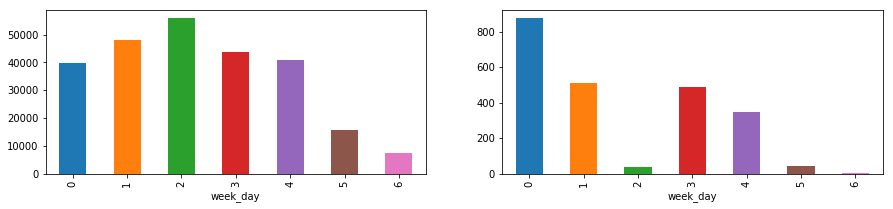

In [22]:
tmp = pd.concat([new_features[:idx_split]['week_day'], y_train], axis = 1)
plt.subplot(1, 2, 1)
tmp[tmp.target == 0].groupby('week_day').size().plot(kind = 'bar')
plt.subplot(1, 2, 2)
tmp[tmp.target == 1].groupby('week_day').size().plot(kind = 'bar', figsize=(15,3))

In [23]:
new_features['week_start'] = new_features['week_day'].apply(lambda x: 1 if x in [0,1] else 0)
new_features['week_midle'] = new_features['week_day'].apply(lambda x: 1 if x in [3, 4] else 0)
new_features.drop('week_day', axis = 1, inplace = True)

In [24]:
# Возьму максимальный, минимальный и средний переход между сайтами
time_lag = pd.DataFrame(index=full_df.index)
time_lag['a1'] = (full_df['time2'] - full_df['time1']).dt.seconds
time_lag['a2'] = (full_df['time3'] - full_df['time2']).dt.seconds
time_lag['a3'] = (full_df['time4'] - full_df['time3']).dt.seconds
time_lag['a4'] = (full_df['time5'] - full_df['time4']).dt.seconds
time_lag['a5'] = (full_df['time6'] - full_df['time5']).dt.seconds
time_lag['a6'] = (full_df['time7'] - full_df['time6']).dt.seconds
time_lag['a7'] = (full_df['time8'] - full_df['time7']).dt.seconds
time_lag['a8'] = (full_df['time9'] - full_df['time8']).dt.seconds
time_lag['a9'] = (full_df['time10'] - full_df['time9']).dt.seconds
time_lag.fillna(999, inplace=True)

In [25]:
new_features['mean_time'] = time_lag.apply(lambda x: x[x != 999].mean(), axis = 1)
new_features['min_time'] = time_lag.apply(lambda x: x[x != 999].min(), axis = 1)
new_features['max_time'] = time_lag.apply(lambda x: x[x != 999].max(), axis = 1)

In [26]:
new_features.fillna(0, inplace=True)

In [108]:
sct = StandardScaler()
tmp_scaled = sct.fit_transform(new_features)
tmp_train = csr_matrix(hstack([full_tfidf[:idx_valid, :],
                              tmp_scaled[:idx_valid, :]]))
cross = cross_val_score(logit, tmp_train, y_train[:idx_valid], cv=time_split, error_score='roc_auc', n_jobs=-1)
cross, cross.mean()

(array([0.96854664, 0.98855748, 0.98237527, 0.52071584, 0.9989154 ,
        0.98828633, 0.99994577, 0.98953362, 0.99962039, 0.97993492]),
 0.9416431670281995)

In [109]:
tmp_train = csr_matrix(hstack([full_tfidf[:idx_split, :],
                              sct.fit_transform(new_features)[:idx_split, :]]))
tmp_test = csr_matrix(hstack([full_tfidf[idx_split:, :],
                             sct.fit_transform(new_features)[idx_split:, :]]))
logit.fit(tmp_train, y_train)
pred = logit.predict_proba(tmp_test)[:, 1]
pd.DataFrame(pred, index=np.arange(1, pred.shape[0] + 1), columns=['target']).to_csv('subs/test.csv', index_label="session_id")

На кросс - 94  
На лидер борде - 92

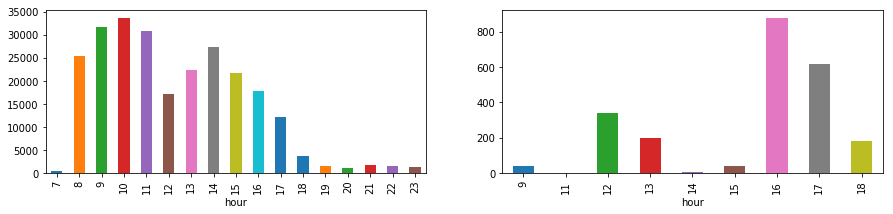

In [27]:
# Время дня
tmp = pd.concat([new_features[:idx_split]['hour'], y_train], axis = 1)
plt.subplot(1, 2, 1)
tmp[tmp.target == 0].groupby('hour').size().plot(kind = 'bar')
plt.subplot(1, 2, 2)
tmp[tmp.target == 1].groupby('hour').size().plot(kind = 'bar', figsize=(15,3))

In [39]:
new_features['morning'] = ((new_features.hour >= 7) & (new_features.hour <= 11)).astype('int')
new_features['day'] = ((new_features.hour >= 12) & (new_features.hour <= 18)).astype('int')
new_features['evening'] = ((new_features.hour >= 19) & (new_features.hour <= 23)).astype('int')
new_features['night'] = ((new_features.hour >= 0) & (new_features.hour <= 6)).astype('int')

### Нужно проверить, что работает лучше - биннинг или onehot

In [43]:
# С бинингом
sct = StandardScaler()
tmp_scaled = sct.fit_transform(new_features.drop('hour', axis = 1))
tmp_train = csr_matrix(hstack([full_tfidf[:idx_valid, :],
                              tmp_scaled[:idx_valid, :]]))
cross = cross_val_score(logit, tmp_train, y_train[:idx_valid], cv=time_split, error_score='roc_auc', n_jobs=-1)
cross, cross.mean()

(array([0.96854664, 0.98720174, 0.98465293, 0.60303688, 0.9989154 ,
        0.98828633, 0.99994577, 0.98953362, 0.99962039, 0.97993492]),
 0.9499674620390455)

In [45]:
from sklearn.preprocessing import OneHotEncoder

In [68]:
# С onehot
onehot = OneHotEncoder()
tmp_scaled = sct.fit_transform(new_features.drop(['hour', 'morning', 'day', 'evening', 'night'], axis = 1))
tmp_onehot = onehot.fit_transform(new_features.hour.values.reshape(-1, 1))
tmp_train = csr_matrix(hstack([full_tfidf[:idx_valid, :],
                             tmp_scaled[:idx_valid, :],
                             tmp_onehot[:idx_valid, :]]))
cross = cross_val_score(logit, tmp_train, y_train[:idx_valid], cv=time_split, error_score='roc_auc', n_jobs=-1)
cross, cross.mean()

(array([0.96854664, 0.99360087, 0.98481562, 0.67163774, 0.9989154 ,
        0.98828633, 0.99994577, 0.989859  , 0.99962039, 0.97998915]),
 0.9575216919739697)

### И бининг и onehot улучшают результаты. Хочу глянуть улучится ли результат на кагле

In [73]:
tmp_train = csr_matrix(hstack([full_tfidf[:idx_split, :],
                              sct.fit_transform(new_features.drop(['hour', 'morning', 'day', 'evening', 'night'], axis = 1))[:idx_split, :],
                              onehot.fit_transform(new_features.hour.values.reshape(-1, 1)[:idx_split, :])]))
tmp_test = csr_matrix(hstack([full_tfidf[idx_split:, :],
                             sct.fit_transform(new_features.drop(['hour', 'morning', 'day', 'evening', 'night'], axis = 1))[idx_split:, :],
                             onehot.fit_transform(new_features.hour.values.reshape(-1, 1)[idx_split:, :])]))
logit.fit(tmp_train, y_train)
pred = logit.predict_proba(tmp_test)[:, 1]
pd.DataFrame(pred, index=np.arange(1, pred.shape[0] + 1), columns=['target']).to_csv('subs/test.csv', index_label="session_id")

**На кроссвалидации - 95,7**  
**На кагле - 93,7**

In [32]:
onehot_hours = onehot.fit_transform(new_features.hour.values.reshape(-1, 1))
new_features.drop(['hour', 'morning', 'day', 'evening', 'night'], axis = 1, inplace = True)

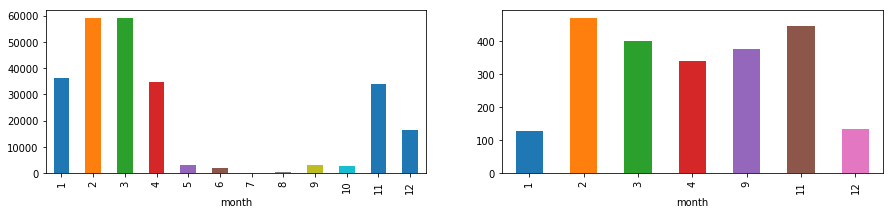

In [33]:
# Время дня
tmp = pd.concat([new_features[:idx_split]['month'], y_train], axis = 1)
plt.subplot(1, 2, 1)
tmp[tmp.target == 0].groupby('month').size().plot(kind = 'bar')
plt.subplot(1, 2, 2)
tmp[tmp.target == 1].groupby('month').size().plot(kind = 'bar', figsize=(15,3))

In [79]:
# С onehot
tmp_scaled = sct.fit_transform(new_features.drop('month', axis = 1))
tmp_onehot = onehot.fit_transform(new_features.month.values.reshape(-1, 1))
tmp_train = csr_matrix(hstack([full_tfidf[:idx_valid, :],
                               onehot_hours[:idx_valid, :],
                               tmp_scaled[:idx_valid, :],
                               tmp_onehot[:idx_valid, :]]))
cross = cross_val_score(logit, tmp_train, y_train[:idx_valid], cv=time_split, error_score='roc_auc', n_jobs=-1)
cross, cross.mean()

(array([0.96854664, 0.99370933, 0.98492408, 0.6681128 , 0.9989154 ,
        0.98503254, 0.99994577, 0.99007592, 0.99962039, 0.97988069]),
 0.956876355748373)

### На дни и месяца onehot не дает результата

In [88]:
new_features['week_day'] = full_df.time1.dt.weekday
new_features['holiday'] = new_features['week_day'].apply(lambda x: 1 if x > 5 else 0)

tmp_scaled = sct.fit_transform(new_features.drop('week_day', axis = 1))
tmp_train = csr_matrix(hstack([full_tfidf[:idx_valid, :],
                               onehot_hours[:idx_valid, :],
                               tmp_scaled[:idx_valid, :]]))
cross = cross_val_score(logit, tmp_train, y_train[:idx_valid], cv=time_split, error_score='roc_auc', n_jobs=-1)
cross, cross.mean()

(array([0.96854664, 0.99360087, 0.98481562, 0.66415401, 0.9989154 ,
        0.98828633, 0.99994577, 0.989859  , 0.99962039, 0.97998915]),
 0.9567733188720174)

In [36]:
new_features.drop('week_day', axis = 1, inplace=True)

### Это пока все с временными фичами. Нужно будет сделать их перебор. Сейчас буду пробовать сделать что то с сайтами

In [37]:
from sklearn.feature_selection import VarianceThreshold

In [117]:
VarianceThreshold(.00005).fit_transform(full_tfidf).shape

(336358, 2393)

In [118]:
# С onehot
tmp_scaled = sct.fit_transform(new_features)
tmp_train = csr_matrix(hstack([VarianceThreshold(.00005).fit_transform(full_tfidf[:idx_valid, :]),
                               onehot_hours[:idx_valid, :],
                               tmp_scaled[:idx_valid, :]]))
cross = cross_val_score(logit, tmp_train, y_train[:idx_valid], cv=time_split, error_score='roc_auc', n_jobs=-1)
cross, cross.mean()

(array([0.96854664, 0.99360087, 0.98481562, 0.66334056, 0.9989154 ,
        0.98828633, 0.99994577, 0.98969631, 0.99962039, 0.97988069]),
 0.9566648590021692)

In [116]:
tmp_tfidf = VarianceThreshold(.0001).fit_transform(full_tfidf)
tmp_train = csr_matrix(hstack([tmp_tfidf[:idx_split, :],
                              sct.fit_transform(new_features)[:idx_split, :],
                              onehot_hours[:idx_split, :]]))
tmp_test = csr_matrix(hstack([tmp_tfidf[idx_split:, :],
                             sct.transform(new_features)[idx_split:, :],
                             onehot_hours[idx_split:, :]]))
logit.fit(tmp_train, y_train)
pred = logit.predict_proba(tmp_test)[:, 1]
pd.DataFrame(pred, index=np.arange(1, pred.shape[0] + 1), columns=['target']).to_csv('subs/mysub5.csv', index_label="session_id")

**С таким набором tf-idf переменных я почти не теряю в качестве**  
**Попробую добавить еще tf-idf пемененных и отсекать их по дисперсии**

In [38]:
tf_idf = TfidfVectorizer(ngram_range=(2, 3), max_features=100000)
full_tfidf_combs = tf_idf.fit_transform(full_df['text'])

In [39]:
tf_idf = TfidfVectorizer()
full_tfidf = tf_idf.fit_transform(full_df['text'])

In [42]:
VarianceThreshold(.00005).fit_transform(full_tfidf_combs).shape

(336358, 2287)

In [136]:
VarianceThreshold(.00005).fit_transform(full_tfidf).shape

(336358, 1591)

In [41]:
# С onehot
sct = StandardScaler()
tmp_scaled = sct.fit_transform(new_features)
tmp_train = csr_matrix(hstack([VarianceThreshold(.00005).fit_transform(full_tfidf)[:idx_valid, :],
                               VarianceThreshold(.00005).fit_transform(full_tfidf_combs)[:idx_valid, :],
                               onehot_hours[:idx_valid, :],
                               tmp_scaled[:idx_valid, :]]))
cross = cross_val_score(logit, tmp_train, y_train[:idx_valid], cv=time_split, error_score='roc_auc', n_jobs=-1)
cross, cross.mean()

(array([0.96854664, 0.99224512, 0.98481562, 0.65254881, 0.99896963,
        0.98882863, 0.99994577, 0.99143167, 0.99962039, 0.97960954]),
 0.9556561822125813)